# Overview

In this post we'll have a look at what's know as **variational inference (VI)**, a family of _approximate_ Bayesian inference methods. In particular, we will focus on one of the more standard VI methods called **Automatic Differentation Variational Inference (ADVI)**.

After having a look at the theory behind VI, we'll show you how you can make use of VI in Turing.jl to approximate complex models.

## Reading guide

- Completely unfamiliar with VI → read everything
- Familiar with VI but not with ADVI → skip to [Automatic Differentiation Variational Inference (ADVI)](#Automatic-Differentiation-Variational-Inference-(ADVI%29)
- Familiar with ADVI → skip to [ADVI in Turing.jl](#ADVI-in-Turing.jl)
- Familiar with ADVI and it's implementation in Turing.jl → https://turing.ml/dev/docs/contributing/guide (he he he)

# Motivation

In Bayesian inference one usually specifies a model as follows: given data $\left\{ x_i \right\}_{i = 1}^n$, 
\begin{equation*}
\begin{split}
  \text{prior:     } \quad z &\sim p(z)  \\
  \text{likelihood:} \quad x_i &\overset{\text{i.i.d.}}{\sim} p(x \mid z) \quad  \text{where} \quad i = 1, \dots, n
\end{split}
\end{equation*}
where $\overset{\text{i.i.d.}}{\sim}$ denotes that the samples are identically independently distributed. Our goal in Bayesian inference is then to find the _posterior_
\begin{equation*}
p(z \mid \{ x_i \}_{i = 1}^n) = \prod_{i=1}^{n} p(z \mid x_i)
\end{equation*}
In general one cannot obtain a closed form expression for $p(z \mid \{ x_i \}_{i = 1}^n)$, but one might still be able to _sample_ from $p(z \mid \{ x_i \}_{i = 1}^n)$ with guarantees of converging to the target posterior $p(z \mid \{ x_i \}_{i = 1}^n)$ as the number of samples go to $\infty$, e.g. MCMC.

As you are hopefully already aware, Turing.jl provides a lot of different methods with asymptotic exactness guarantees that we can apply to such a problem!

Unfortunately, these unbiased samplers can be prohibitively expensive to run. As the model $p$ increases in complexity, the convergence of these unbiased samplers can slow down dramatically. Still, in the _infinite_ limit, these methods should converge to the true posterior! But infinity is fairly large, like, _at least_ more than 12, so this might take a while. 

In such a case it might be desirable to sacrifice some of these asymptotic guarantees, and instead _approximate_ the posterior $p(z \mid \{x_i\}_{i = 1}^n)$ using some other model which we'll denote $q(z)$.

There are multiple approaches to take in this case, one of which is **variational inference (VI)**.

# Variational Inference (VI)

In VI, we're looking to approximate $p(z \mid \{ x_i \}_{i = 1}^n )$ using some _approximate_ or _variational_ posterior $q(z)$.

To approximate something you need a notion of what "close" means. In the context of probability densities a standard such "measure" of closeness is the _Kullback-Leibler (KL) divergence_, though this is far from the only one. The KL-divergence is defined between two densities $q(z)$ and $p(z \mid \{ x_i \}_{i = 1}^n)$ as

\begin{equation*}
\begin{split}
  \mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) &= \int \log \bigg( \frac{q(z)}{\sum_{i = 1}^n p(z \mid x_i)} \bigg) q(z) \mathrm{d}{z} \\
  &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) - \sum_{i = 1}^n \log p(z \mid x_i) \big] \\
  &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(z \mid x_i) \big]
\end{split}
\end{equation*}


It's worth noting that unfortunately the KL-divergence is _not_ a metric/distance in the analysis-sense due to its lack of symmetry. On the other hand, it turns out that minimizing the KL-divergence that it's actually equivalent to maximizing the log-likelihood! [INSERT REF?] Also, under reasonable restrictions on the densities at hand,

\begin{equation*}
\mathrm{D_{KL}}\big(q(z), p(z \mid \{x_i\}_{i = 1}^n) \big) = 0 \quad \iff \quad p(z) = p(z \mid \{x_i\}_{i = 1}^n), \quad \forall z
\end{equation*}

Therefore one could (and we will) attempt to approximate $p(z \mid \{x_i\}_{i = 1}^n)$ using a density $q(z)$ by minimizing the KL-divergence between these two!

One can also show that $\mathrm{D_{KL}} \ge 0$, which we'll need later. Finally notice that the KL-divergence is only well-defined when in fact $q(z)$ is zero everywhere where $p(z \mid \{x_i\}_{i = 1}^n)$ is zero, i.e.

\begin{equation*}
\mathrm{supp}\big(q(z)\big) \subseteq \mathrm{supp}\big(p(z \mid x)\big)
\end{equation*}

Otherwise there might be a point $z_0 \sim q(z)$ such that $p(z_0 \mid \{x_i\}_{i = 1}^n) = 0$, resulting in $\log\big(\frac{q(z)}{0}\big)$ which doesn't make sense!

One major problem: as we can see in the definition of the KL-divergence, we need $p(z \mid \{x_i\}_{i = 1}^n)$ for any $z$ if we want to compute the KL-divergence between this and $q(z)$. We don't have that. The entire reason we even do Bayesian inference is that we don't know the posterior! Cleary this isn't going to work. _Or is it?!_

## Computing $\mathrm{D_{KL}}$ without the posterior

First off, recall that

\begin{equation*}
p(z \mid x_i) = \frac{p(x_i, z)}{p(x_i)}
\end{equation*}

so we can write

\begin{equation*}
\begin{split}
\mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) - \log p(x_i) \big] \\
    &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] + \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i) \big] \\ 
    &= \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] - \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] + \sum_{i = 1}^n \log p(x_i)
\end{split}
\end{equation*}

where in the last equality we used the fact that $p(x_i)$ is independent of $z$.

Now you're probably thinking "Oh great! Now you've introduced $p(x_i)$ which we _also_ can't compute (in general)!". Woah. Calm down human. Let's do some more algebra. The above expression can be rearranged to

\begin{equation*}
\mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) + \underbrace{\sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] - \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big]}_{=: \mathrm{ELBO}(q)} = \underbrace{\sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i) \big]}_{\text{constant}}
\end{equation*}

See? The left-hand side is _constant_ and, as we mentioned before, $\mathrm{D_{KL}} \ge 0$. What happens if we try to _maximize_ the term we just gave the completely arbitrary name $\mathrm{ELBO}$? Well, if $\mathrm{ELBO}$ goes up while $p(x_i)$ stays constant then $\mathrm{D_{KL}}$ _has to_ go down! That is, the $q(z)$ which _minimizes_ the KL-divergence is the same $q(z)$ which _maximizes_ $\mathrm{ELBO}(q)$:

\begin{equation*}
\underset{q}{\mathrm{argmin}} \ \mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) = \underset{q}{\mathrm{argmax}} \ \mathrm{ELBO}(q)
\end{equation*}

where

\begin{equation*}
\begin{split}
\mathrm{ELBO}(q) &:= \bigg( \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big]  \bigg) - \mathbb{E}_{z \sim q(z)} \big[ \log q(z) \big] \\
    &= \bigg( \sum_{i = 1}^n \mathbb{E}_{z \sim q(z)} \big[ \log p(x_i, z) \big] \bigg) + \mathbb{H}\big( q(z) \big)
\end{split}
\end{equation*}

and $\mathbb{H} \big(q(z) \big)$ denotes the [(differential) entropy](https://www.wikiwand.com/en/Differential_entropy) of $q(z)$.

Assuming joint $p(x_i, z)$ and the entropy $\mathbb{H}\big(q(z)\big)$ are both tractable, we can use a Monte-Carlo for the remaining expectation. This leaves us with the following tractable expression

\begin{equation*}
\underset{q}{\mathrm{argmin}} \ \mathrm{D_{KL}} \big( q(z), p(z \mid \{ x_i \}_{i = 1}^n) \big) \approx \underset{q}{\mathrm{argmax}} \ \widehat{\mathrm{ELBO}}(q)
\end{equation*}
where
\begin{equation*}
\widehat{\mathrm{ELBO}}(q) = \frac{1}{m} \bigg( \sum_{k = 1}^m \sum_{i = 1}^n \log p(x_i, z_k) \bigg) + \mathbb{H} \big(q(z)\big) \quad \text{where} \quad z_k \sim q(z) \quad \forall k = 1, \dots, m
\end{equation*}

Hence, as long as we can sample from $q(z)$ somewhat efficiently, we can indeed minimize the KL-divergence! Neat, eh?

Sidenote: in the case where $q(z)$ is tractable but $\mathbb{H} \big(q(z) \big)$ is _not_, we can use an Monte-Carlo estimate for this term too but this generally results in a higher-variance estimate.

Also, I fooled you real good: the ELBO _isn't_ an arbitrary name, hah! In fact it's an abbreviation for the **expected lower bound (ELBO)** because it, uhmm, well, it's the _expected_ lower bound (remember $\mathrm{D_{KL}} \ge 0$). Yup.

## Maximizing $\widehat{\mathrm{ELBO}}(q)$

Finding the optimal $q$ over _all_ possible densities of course isn't feasible. Instead we consider a family of _parameterized_ densities $\mathscr{D}_{\Theta}$ where $\Theta$ denotes the space of possible parameters. Each density in this family $q_{\theta} \in \mathscr{D}_{\Theta}$ is parameterized by a unique $\theta \in \Theta$. Moreover, we'll assume
1. $q_{\theta}(z)$, i.e. evaluating the probability density $q$ at any point $z$, is differentiable
2. $z \sim q_{\theta}(z)$, i.e. the process of sampling from $q_{\theta}(z)$, is differentiable

(1) is fairly straight-forward, but (2) is a bit tricky. What does it even mean for a _sampling process_ to be differentiable? This is quite an interesting problem in its own right and would require something like a [50-page paper to properly review the different approaches (highly recommended read)](https://arxiv.org/abs/1906.10652).

We're going to make use of a particular such approach which goes under a bunch of different names: _reparametrization trick_, _path derivative_, etc. This refers to making the assumption that all elements $q_{\theta} \in \mathscr{Q}_{\Theta}$ can be considered as reparameterizations of some base density, say $\bar{q}(z)$. That is, if $q_{\theta} \in \mathscr{Q}_{\Theta}$ then

\begin{equation*}
z \sim q_{\theta}(z) \quad \iff \quad z := g_{\theta}(\tilde{z}) \quad \text{where} \quad \bar{z} \sim \bar{q}(z)
\end{equation*}

for some function $g_{\theta}$ differentiable wrt. $\theta$. So all $q_{\theta} \in \mathscr{Q}_{\Theta}$ are using the *same* reparameterization-function $g$ but each $q_{\theta}$ correspond to different choices of $\theta$ for $f_{\theta}$.

Under this assumption we can differentiate the sampling process by taking the derivative of $g_{\theta}$ wrt. $\theta$, and thus we can differentiate the entire $\widehat{\mathrm{ELBO}}(q_{\theta})$ wrt. $\theta$! With the gradient available we can either try to solve for optimality either by setting the gradient equal to zero or maximize $\widehat{\mathrm{ELBO}}(q_{\theta})$ stepwise by traversing $\mathscr{Q}_{\Theta}$ in the direction of steepest ascent. For the sake of generality, we're going to go with the stepwise approach.

With all this nailed down, we eventually reach the section on **Automatic Differentiation Variational Inference (ADVI)**.

## Automatic Differentiation Variational Inference (ADVI)

So let's revisit the assumptions we've made at this point:
1. The variational posterior $q_{\theta}$ is in a parameterized family of densities denoted $\mathscr{Q}_{\Theta}$, with $\theta \in \Theta$.
2. $\mathscr{Q}_{\Theta}$ is a space of _reparameterizable_ densities with $\bar{q}(z)$ as the base-density.
3. The parameterization function $g_{\theta}$ is differentiable wrt. $\theta$.
4. Evaluation of the probability density $q_{\theta}(z)$ is differentiable wrt. $\theta$.
5. $\mathbb{H}\big(q_{\theta}(z)\big)$ is tractable.
6. Evaluation of the joint density $p(x, z)$ is tractable and differentiable wrt. $z$
7. The support of $p(z \mid x)$ is a subspace of the support of $q(z)$: $\mathrm{supp}\big(p(z \mid x)\big) \subseteq \mathrm{supp}\big(q(z)\big)$.


All of these are not *necessary* to do VI, but they are very convenient and results in a fairly flexible approach. One distribution which has a density satisfying all of the above assumptions _except_ (7) (we'll get back to this in second) for any tractable and differentiable $p(z \mid \{x_i\}_{i = 1}^n)$ is the good ole' Gaussian/normal distribution:

\begin{equation*}
z \sim \mathcal{N}(\mu, \Sigma) \quad \iff \quad z = g_{\mu, L}(\bar{z}) := \mu + L^T \tilde{z} \quad \text{where} \quad \bar{z} \sim \bar{q}(z) := \mathcal{N}(1_d, I_{d \times d})
\end{equation*}

where $\Sigma = L L^T$, with $L$ obtained from the Cholesky-decomposition. Abusing notation a bit, we're going to write

\begin{equation*}
\theta = (\mu, \Sigma) := (\mu_1, \dots, \mu_d, L_{11}, \dots, L_{1, d}, L_{2, 1}, \dots, L_{2, d}, \dots, L_{d, 1}, \dots, L_{d, d})
\end{equation*}

With this assumption we finally have a tractable expression for $\widehat{\mathrm{ELBO}}(q_{\mu, \Sigma})$! Well, assuming (7) is holds. Since a Gaussian has non-zero probability on the entirety of $\mathbb{R}^d$, we also require $p(z \mid \{x_i\}_{i = 1}^n)$ to have non-zero probability on all of $\mathbb{R}^d$.

Though not necessary, we'll often make a *mean-field* assumption for the variational posterior $q(z)$, i.e. assume independence between the latent variables. In this case, we'll write

\begin{equation*}
\theta = (\mu, \sigma^2) := (\mu_1, \dots, \mu_d, \sigma_1^2, \dots, \sigma_d^2)
\end{equation*}

### Examples
As a (trivial) example we could apply the approach described above to is the following generative model for $p(z \mid \{x_i\}_{i = 1}^n)$:

\begin{equation*}
\begin{split}
    m &\sim \mathcal{N}(0, 1) \\
    x_i &\overset{\text{i.i.d.}}{=} \mathcal{N}(m, 1), \quad i = 1, \dots, n
\end{split}
\end{equation*}

In this case $z = m$ and we have the posterior defined $p(m \mid \{x_i\}_{i = 1}^n) = p(m) \prod_{i = 1}^n p(x_i \mid m)$. Then the variational posterior would be

\begin{equation*}
q_{\mu, \sigma} = \mathcal{N}(\mu, \sigma^2) \quad \text{where} \quad \mu \in \mathbb{R}, \ \sigma^2 \in \mathbb{R}^{ + }
\end{equation*}

And since prior of $m$, $\mathcal{N}(0, 1)$, has non-zero probability on the entirety of $\mathbb{R}$, same as $q(m)$, i.e. assumption (7) above holds, everything is fine and life is good.

But what about this generative model for $p(z \mid \{x_i\}_{i = 1}^n)$:

\begin{equation*}
\begin{split}
    s &\sim \mathrm{InverseGamma}(2, 3) \\
    m &\sim \mathcal{N}(0, s) \\
    x_i &\overset{\text{i.i.d.}}{=} \mathcal{N}(m, s), \quad i = 1, \dots, n
\end{split}
\end{equation*}

with posterior $p(s, m \mid \{x_i\}_{i = 1}^n) = p(s) p(m \mid s) \prod_{i = 1}^n p(x_i \mid s, m)$ and the mean-field variational posterior $q(s, m)$ will be

\begin{equation*}
q_{\mu_1, \mu_2, \sigma_1^2, \sigma_2^2}(s, m) = p_{\mathcal{N}(\mu_1, \sigma_1^2)}(s) p_{\mathcal{N}(\mu_2, \sigma_2^2)}(m)
\end{equation*}

where we've denoted the evaluation of the probability density of a Gaussian as $p_{\mathcal{N}(\mu, \sigma^2)}(x)$.

Observe that $\mathrm{InverseGamma}(2, 3)$ has non-zero probability only on $\mathbb{R}^{ + } := (0, \infty)$ which is clearly not all of $\mathbb{R}$ like $q(s, m)$ has, i.e.

\begin{equation*}
\mathrm{supp} \big( q(s, m) \big) \not\subseteq \mathrm{supp} \big( p(z \mid \{x_i\}_{i = 1}^n) \big)
\end{equation*}

Recall from the definition of the KL-divergence that when this is the case, the KL-divergence isn't well defined. This gets us to the *automatic* part of ADVI.

### "Automatic"? How?

For a lot of the standard (continuous) densities $p$ we can actually construct a probability density $\tilde{p}$ with non-zero probability on all of $\mathbb{R}$ by *transforming* the "constrained" probability density $p$ to $\tilde{p}$. In fact, in these cases this is a one-to-one relationship. As we'll see, this helps solve the support-issue we've been going on and on about.

#### Transforming densities using change of variables

If we want to compute the probability of $x$ taking a value in some set $A \subseteq \mathrm{supp} \big( p(x) \big)$, we have to integrate $p(x)$ over $A$, i.e.

\begin{equation*}
\mathbb{P}_p(x \in A) = \int_A p(x) \mathrm{d}x
\end{equation*}

This means that if we have a differentiable bijection $f: \mathrm{supp} \big( q(x) \big) \to \mathbb{R}^d$ with differentiable inverse $f^{-1}: \mathbb{R}^d \to \mathrm{supp} \big( p(x) \big)$, we can perform a change of variables

\begin{equation*}
\mathbb{P}_p(x \in A) = \int_{f^{-1}(A)} p \big(f^{-1}(y) \big) \ \big| \det \mathcal{J}_{f^{-1}}(y) \big| \ \mathrm{d}y
\end{equation*}

where $\mathcal{J}_{f^{-1}}(x)$ denotes the jacobian of $f^{-1}$ evaluted at $x$. Observe that this defines a probability distribution

\begin{equation*}
\mathbb{P}_{\tilde{p}}\big(y \in f^{-1}(A) \big) = \int_{f^{-1}(A)} \tilde{p}(y) \mathrm{d}y
\end{equation*}

since $f^{-1}\big(\mathrm{supp} (p(x)) \big) = \mathbb{R}^d$ which has probability 1. This probability distribution has *density* $\tilde{p}(y)$ with $\mathrm{supp} \big( \tilde{p}(y) \big) = \mathbb{R}^d$, defined

\begin{equation*}
\tilde{p}(y) = p \big( f^{-1}(y) \big) \ \big| \det \mathcal{J}_{f^{-1}}(y) \big|
\end{equation*}

or equivalently

\begin{equation*}
\tilde{p} \big( f(x) \big) = \frac{p(x)}{\big| \det \mathcal{J}_{f}(x) \big|}
\end{equation*}

due to the fact that

\begin{equation*}
\big| \det \mathcal{J}_{f^{-1}}(y) \big| = \big| \det \mathcal{J}_{f}(x) \big|^{-1}
\end{equation*}

*Note: it's also necessary that the log-abs-det-jacobian term is non-vanishing. This can for example be accomplished by assuming $f$ to also be elementwise monotonic.*

#### Back to VI

So why is this is useful? Well, we're looking to generalize our approach using a normal distribution to cases where the supports don't match up. How about defining $q(z)$ by

\begin{equation*}
\begin{split}
  \eta &\sim \mathcal{N}(\mu, \Sigma) \\
  z &= f^{-1}(\eta)
\end{split}
\end{equation*}

where $f^{-1}: \mathbb{R}^d \to \mathrm{supp} \big( p(z \mid x) \big)$ is a differentiable bijection with differentiable inverse. Then $z \sim q_{\mu, \Sigma}(z) \implies z \in \mathrm{supp} \big( p(z \mid x) \big)$ as we wanted. The resulting variational density is

\begin{equation*}
q_{\mu, \Sigma}(z) = p_{\mathcal{N}(\mu, \Sigma)}\big( f(z) \big) \ \big| \det \mathcal{J}_{f}(z) \big|
\end{equation*}

Note that the way we've constructed $q(z)$ here is basically a reverse of the approach we described above. Here we sample from a distribution with support on $\mathbb{R}$ and transform *to* $\mathrm{supp} \big( p(z \mid x) \big)$.

If we want to write the ELBO explicitly in terms of $\eta$ rather than $z$, the first term in the ELBO becomes

\begin{equation*}
\begin{split}
  \mathbb{E}_{z \sim q_{\mu, \Sigma}(z)} \big[ \log p(x_i, z) \big] &= \mathbb{E}_{\eta \sim \mathcal{N}(\mu, \Sigma)} \Bigg[ \log \frac{p\big(x_i, f^{-1}(\eta) \big)}{\big| \det \mathcal{J}_{f^{-1}}(\eta) \big|} \Bigg] \\
  &= \mathbb{E}_{\eta \sim \mathcal{N}(\mu, \Sigma)} \big[ \log p\big(x_i, f^{-1}(\eta) \big) \big] - \mathbb{E}_{\eta \sim \mathcal{N}(\mu, \Sigma)} \big[ \big| \det \mathcal{J}_{f^{-1}}(\eta) \big| \big]
\end{split}
\end{equation*}

The entropy is invariant under change of variables, thus $\mathbb{H} \big(q_{\mu, \Sigma}(z)\big)$ is simply the entropy of the normal distribution which is known analytically. 

Hence, the resulting empirical estimate of the ELBO is

\begin{equation*}
\begin{split}
\widehat{\mathrm{ELBO}}(q_{\mu, \Sigma}) &= \frac{1}{m} \bigg( \sum_{k = 1}^m \sum_{i = 1}^n \Big(\log p\big(x_i, f^{-1}(\eta_k)\big) - \log \big| \det \mathcal{J}_{f^{-1}}(\eta_k) \big| \Big) \bigg) + \mathbb{H} \big(p_{\mathcal{N}(\mu, \Sigma)}(z)\big) \\
& \text{where} \quad z_k  \sim \mathcal{N}(\mu, \Sigma) \quad \forall k = 1, \dots, m
\end{split}
\end{equation*}

And maximizing this wrt. $\mu$ and $\Sigma$ is what's referred to as **Automatic Differentation Variational Inference (ADVI)**!

# Variational inference (VI) in Turing.jl

In this post we'll have a look at what's know as **variational inference (VI)**, a family of _approximate_ Bayesian inference methods, and how to use it in Turing.jl as an alternative to other approaches such as MCMC. In particular, we will focus on one of the more standard VI methods called **Automatic Differentation Variational Inference (ADVI)**.

Using VI in Turing.jl is very straight forward. If `model` denotes a definition of a `Turing.Model`, performing VI is as simple as
```julia
m = model(data...) # instantiate model on the data
q = vi(m, vi_alg)  # perform VI on `m` using the VI method `vi_alg`, which returns a `VariationalPosterior`
```
Thus it's no more work than standard MCMC sampling in Turing.

To get a bit more into what we can do with `vi`, we'll first have a look at a simple example and then we'll reproduce the [tutorial on Bayesian linear regression](5_LinearRegression.ipynb) using VI instead of MCMC. Finally we'll look at some of the different parameters of `vi` and how you for example can use your own custom variational family.

## Setup

In [128]:
using Random
using Turing
using Turing: Variational

Random.seed!(42);

## Simple example: Normal-Gamma conjugate model

The Normal-(Inverse)Gamma conjugate model is defined by the following generative process

\begin{equation*}
\begin{split}
    s &\sim \mathrm{InverseGamma}(2, 3) \\
    m &\sim \mathcal{N}(0, s) \\
    x_i &\overset{\text{i.i.d.}}{=} \mathcal{N}(m, s), \quad i = 1, \dots, n
\end{split}
\end{equation*}

Recall that *conjugate* refers to the fact that we can obtain a closed-form expression for the posterior. Of course one wouldn't use something like variational inference for a conjugate model, but it's useful as a simple demonstration as we can compare the result to the true posterior.

First we generate some synthetic data, define the `Turing.Model` and instantiate the model on the data:

In [129]:
# generate data, n = 2000
x = randn(2000);

In [130]:
@model model(x) = begin
    s ~ InverseGamma(2, 3)
    m ~ Normal(0.0, sqrt(s))
    for i = 1:length(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

##model#799 (generic function with 2 methods)

In [131]:
# construct model
m = model(x);

Now we'll produce some samples from the posterior using a MCMC method, which in constrast to VI is guaranteed to converge to the *exact* posterior (as the number of samples go to infinity).

We'll produce 10 000 samples with 200 steps used for adaptation and a target acceptance rate of 0.65

If you don't understand what "adaptation" or "target acceptance rate" refers to, all you really need to know is that `NUTS` is known to be one of the most accurate and efficient samplers (when applicable) while requiring little to no hand-tuning to work well.

In [132]:
samples_nuts = sample(m, NUTS(200, 0.65), 10000);

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /var/home/tef30/.julia/dev/Turing/src/inference/hmc.jl:553
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


Now let's try VI. The most important function you need to now about to do VI in Turing is `vi`:

In [133]:
?Variational.vi

```
vi(model, alg::VariationalInference)
vi(model, alg::VariationalInference, q::VariationalPosterior)
vi(model, alg::VariationalInference, getq::Function, θ::AbstractArray)
```

Constructs the variational posterior from the `model` and performs the optimization following the configuration of the given `VariationalInference` instance.

# Arguments

  * `model`: `Turing.Model` or `Function` z ↦ log p(x, z) where `x` denotes the observations
  * `alg`: the VI algorithm used
  * `q`: a `VariationalPosterior` for which it is assumed a specialized implementation of the variational objective used exists.
  * `getq`: function taking parameters `θ` as input and returns a `VariationalPosterior`
  * `θ`: only required if `getq` is used, in which case it is the initial parameters for the variational posterior


`vi` takes the `Model` you want to approximate, a `VariationalInference` whose type specifies the method to use and then its fields specify the configuration of the method. 

Additionally, you can pass
- an initial variational posterior `q`, for which we assume there exists a implementation of `update(::typeof(q), θ::AbstractVector)` returning an updated posterior `q` with parameters `θ`.
- a function mapping $\theta \mapsto q_{\theta}$ (denoted above `getq`) together with initial parameters `θ`. This provides more flexibility in the types of variational families that we can use, and can sometimes be slightly more convenient for quick and rough work.

By default, i.e. when calling `vi(m, advi)`, Turing will obtain `q` by calling `Variational.meanfield(model)` for which there exists an internal implementation for `update`:

In [134]:
?Variational.meanfield

```
meanfield(model::Model)
meanfield(rng::AbstractRNG, model::Model)
```

Creates a mean-field approximation with multivariate normal as underlying distribution.


**IMPORTANT:** As of writing, `VariationalInference` is just an alias for `MultivariateDistribution`. This means that when you pass `vi` a `q`, we're assuming that `rand(q, num_samples)` produce samples which are of the same length as there are latent variables in your `Model`. Moreover, right now the subsequent calls, e.g. `elbo`, are only defined for the particular case of a mean-field normal though the only non-general implementation detail is the parameter handling. Therefore making this general in the future is straight forward. Then you'll be able to perform VI using basically arbitrary variational posteriors, assuming of course that it has the correct output.

Currently the only implementation of `VariationalInference` available is `ADVI`, which is very convenient and applicable as long as your `Model` is differentiable with respect to the variational parameters:

In [135]:
?Variational.ADVI

```julia
struct ADVI{AD} <: Turing.Variational.VariationalInference{AD}
```

Automatic Differentiation Variational Inference (ADVI) with automatic differentiation backend `AD`.

# Fields

  * `samples_per_step::Int64`

    Number of samples used to estimate the ELBO in each optimization step.
  * `max_iters::Int64`

    Maximum number of gradient steps.

---

```
ADVI([samples_per_step=1, max_iters=1000])
```

Create an [`ADVI`](@ref) with the currently enabled automatic differentiation backend `ADBackend()`.


To perform VI on the model `m` using 10 samples for gradient estimation and taking 1000 gradient steps is then as simple as:

In [136]:
# ADVI
advi = ADVI(10, 1000)
q = vi(m, advi);

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 14786953465862058014
└ @ Turing.Variational /var/home/tef30/.julia/dev/Turing/src/variational/VariationalInference.jl:161
[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:09


Unfortunately, for such a small problem Turing's new `NUTS` sampler is *so* efficient now that it's not that much more efficient to use ADVI. So, so very unfortunate...

With that being said, this is not the case in general. For very complex models we'll later find that `ADVI` produces very reasonable results in a much shorter time than `NUTS`.

And one significant advantage of using `vi` is that we can sample from the resulting `q` with ease. In fact, the result of the `vi` call is a `TransformedDistribution` from Bijectors.jl, and

In [137]:
q isa MultivariateDistribution

true

it implements the Distributions.jl interface for a `Distribution`! This means that we can call `rand` to sample from the variational posterior `q`:

In [138]:
rand(q)

2-element Array{Float64,1}:
  1.0134702063474585 
 -0.07429020521027016

and `logpdf` to compute the log-probability

In [139]:
logpdf(q, rand(q))

4.277478745320889

Let's check the first and second moments of the data to see how our approximation compares to the point-estimates form the data:

In [140]:
var(x), mean(x)

(1.0211094595750467, -0.028838703049547422)

In [141]:
(mean(rand(q, 1000); dims = 2)..., )

(1.02716749432684, -0.02510701319723139)

That's pretty close! But we're Bayesian so we're not interested in just matching the expected value.
Let's instead look the actual density `q`. 

For that we need samples:

In [142]:
samples = rand(q, 10000);

In [143]:
# setup for plotting
using Plots, StatsPlots, LaTeXStrings

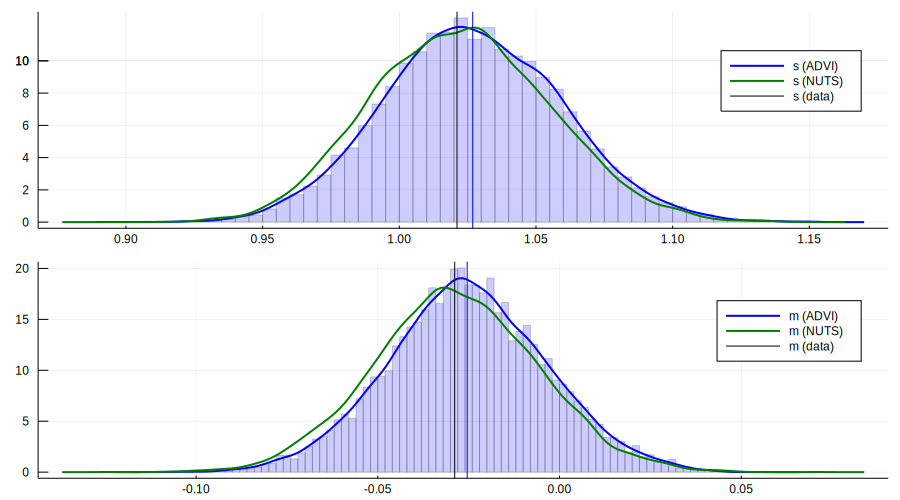

In [144]:
p1 = histogram(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "s (ADVI)", color = :blue, linewidth = 2)
density!(collect(skipmissing(samples_nuts[:s].value)), label = "s (NUTS)", color = :green, linewidth = 2)
vline!([var(x)], label = "s (data)", color = :black)
vline!([mean(samples[1, :])], color = :blue, label ="")

p2 = histogram(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "m (ADVI)", color = :blue, linewidth = 2)
density!(collect(skipmissing(samples_nuts[:m].value)), label = "m (NUTS)", color = :green, linewidth = 2)
vline!([mean(x)], color = :black, label = "m (data)")
vline!([mean(samples[2, :])], color = :blue, label="")

plot(p1, p2, layout=(2, 1), size=(900, 500))

For this particular `Model`, we can in fact obtain the posterior of the latent variables in closed form. This allows us to compare both `NUTS` and `ADVI` to the true posterior $p(s, m \mid \{x_i\}_{i = 1}^n )$.

*The code below is just work to get the marginals $p(s \mid \{x_i\}_{i = 1}^n)$ and $p(m \mid \{x_i\}_{i = 1}^n$ from the posterior obtained using ConjugatePriors.jl. Feel free to skip it.*

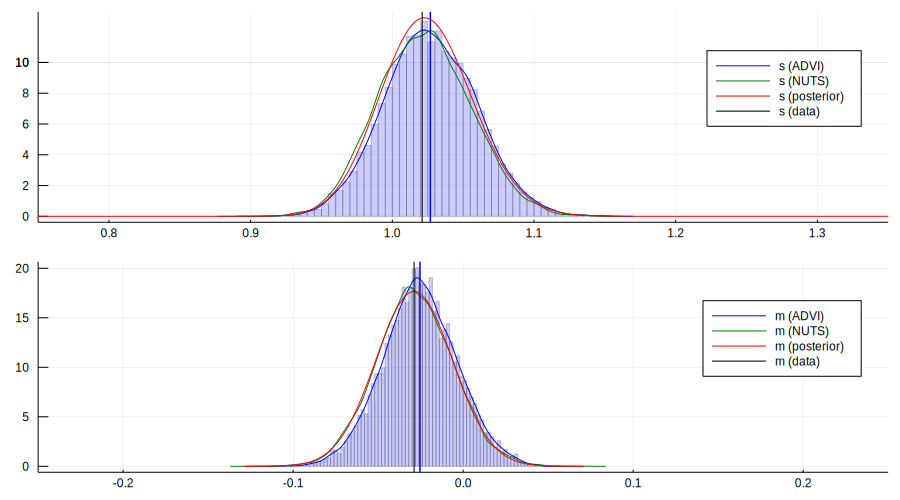

In [145]:
# used to compute closed form expression of posterior
using ConjugatePriors

# closed form computation
# notation mapping has been verified by explicitly computing expressions
# in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
μ₀ = 0.0 # => μ
κ₀ = 1.0 # => ν, which scales the precision of the Normal
α₀ = 2.0 # => "shape"
β₀ = 3.0 # => "rate", which is 1 / θ, where θ is "scale"

# prior
pri = NormalGamma(μ₀, κ₀, α₀, β₀)

# posterior
post = posterior(pri, Normal, x)

# marginal distribution of τ = 1 / σ²
# Eq. (90) in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
# `scale(post)` = θ
p_τ = Gamma(post.shape, scale(post))
p_σ²_pdf = z -> pdf(p_τ, 1 / z) # τ => 1 / σ² 

# marginal of μ
# Eq. (91) in "Conjugate Bayesian analysis of the Gaussian distribution" by Murphy
p_μ = TDist(2 * post.shape)

μₙ = post.mu    # μ → μ
κₙ = post.nu    # κ → ν
αₙ = post.shape # α → shape
βₙ = post.rate  # β → rate

# numerically more stable but doesn't seem to have effect; issue is probably internal to
# `pdf` which needs to compute ≈ Γ(1000) 
p_μ_pdf = z -> exp(logpdf(p_μ, (z - μₙ) * exp(- 0.5 * log(βₙ) + 0.5 * log(αₙ) + 0.5 * log(κₙ))))

# posterior plots
p1 = plot();
histogram!(samples[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[1, :], label = "s (ADVI)", color = :blue)
density!(collect(skipmissing(samples_nuts[:s].value)), label = "s (NUTS)", color = :green)
vline!([mean(samples[1, :])], linewidth = 1.5, color = :blue, label ="")

# normalize using Riemann approx. because of (almost certainly) numerical issues
Δ = 0.001
r = 0.75:0.001:1.50
norm_const = sum(p_σ²_pdf.(r) .* Δ)
plot!(r, p_σ²_pdf, label = "s (posterior)", color = :red);
vline!([var(x)], label = "s (data)", linewidth = 1.5, color = :black, alpha = 0.7);
xlims!(0.75, 1.35);

p2 = plot();
histogram!(samples[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samples[2, :], label = "m (ADVI)", color = :blue)
density!(collect(skipmissing(samples_nuts[:m].value)), label = "m (NUTS)", color = :green)
vline!([mean(samples[2, :])], linewidth = 1.5, color = :blue, label="")


# normalize using Riemann approx. because of (almost certainly) numerical issues
Δ = 0.0001
r = -0.1 + mean(x):Δ:0.1 + mean(x)
norm_const = sum(p_μ_pdf.(r) .* Δ)
plot!(r, z -> p_μ_pdf(z) / norm_const, label = "m (posterior)", color = :red);
vline!([mean(x)], label = "m (data)", linewidth = 1.5, color = :black, alpha = 0.7);

xlims!(-0.25, 0.25);

p = plot(p1, p2; layout=(2, 1), size=(900, 500))

# Bayesian linear regression example using `ADVI`

This is simply a duplication of the tutorial [5. Linear regression](5_LinearRegression.ipynb) but now with the addition of an approximate posterior obtained using `ADVI`.

As we'll see, there is really no additional work required to apply variational inference to a more complex `Model`.

## Copy-paste from the other tutorial

This section is basically copy-pasting the code from the linear regression tutorial.

In [146]:
Random.seed!(1);

In [147]:
# Import RDatasets.
using RDatasets

# Hide the progress prompt while sampling.
Turing.turnprogress(true);

┌ Info: [Turing]: progress logging is enabled globally
└ @ Turing /var/home/tef30/.julia/dev/Turing/src/Turing.jl:23


In [148]:
# Import the "Default" dataset.
data = RDatasets.dataset("datasets", "mtcars");

# Show the first six rows of the dataset.
first(data, 6)

,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,String,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Int64
1,Mazda RX4,21.0,6,160.0,110,3.9,2.62,16.46,0
2,Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0
3,Datsun 710,22.8,4,108.0,93,3.85,2.32,18.61,1
4,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1
5,Hornet Sportabout,18.7,8,360.0,175,3.15,3.44,17.02,0
6,Valiant,18.1,6,225.0,105,2.76,3.46,20.22,1


In [149]:
# Function to split samples.
function split_data(df, at = 0.70)
    r = size(df,1)
    index = Int(round(r * at))
    train = df[1:index, :]
    test  = df[(index+1):end, :]
    return train, test
end

# A handy helper function to rescale our dataset.
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

# Another helper function to unstandardize our datasets.
function unstandardize(x, orig)
    return (x .+ mean(orig, dims=1)) .* std(orig, dims=1)
end

unstandardize (generic function with 1 method)

In [150]:
# Remove the model column.
select!(data, Not(:Model))

# Standardize our dataset.
(std_data, data_arr) = standardize(Matrix(data))

# Split our dataset 70%/30% into training/test sets.
train, test = split_data(std_data, 0.7)

# Save dataframe versions of our dataset.
train_cut = DataFrame(train, names(data))
test_cut = DataFrame(test, names(data))

# Create our labels. These are the values we are trying to predict.
train_label = train_cut[:, :MPG]
test_label = test_cut[:, :MPG]

# Get the list of columns to keep.
remove_names = filter(x->!in(x, [:MPG, :Model]), names(data))

# Filter the test and train sets.
train = Matrix(train_cut[:,remove_names]);
test = Matrix(test_cut[:,remove_names]);

In [151]:
# Bayesian linear regression.
@model linear_regression(x, y, n_obs, n_vars, ::Type{T}=Vector{Float64}) where {T} = begin
    # Set variance prior.
    σ₂ ~ truncated(Normal(0,100), 0, Inf)
    
    # Set intercept prior.
    intercept ~ Normal(0, 3)
    
    # Set the priors on our coefficients.
    coefficients ~ MvNormal(zeros(n_vars), 10 * ones(n_vars))
    
    # Calculate all the mu terms.
    mu = intercept .+ x * coefficients
    y ~ MvNormal(mu, σ₂)
end;

In [152]:
n_obs, n_vars = size(train)
m = linear_regression(train, train_label, n_obs, n_vars);

## Performing VI

First we define the initial variational distribution, or, equivalently, the family of distributions to consider. We're going to use the same mean-field approximation as Turing will use by default when we call `vi(m, advi)`, which we obtain by calling `Variational.meanfield`. This returns a `TransformedDistribution` with a `TuringDiagMvNormal` as the underlying distribution and the transformation mapping from the reals to the domain of the latent variables.

In [153]:
q0 = Variational.meanfield(m)

TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [0.45879095505371686, -0.5223367574215084, 0.40839583832475224, -0.050451229933665284, -0.6936536438038856, -1.7738332534080556, 0.12076596493743928, -0.7576330377205277, -1.7297561813906863, 0.7959486220046159, 0.6700619812560624, 0.5508523775007609]
σ: [0.6619618427228414, 1.5701534201641378, 0.6572415551483521, 0.38832839247754786, 0.2586758488998533, 0.6669119488082131, 0.6139838875720897, 0.11385411290185252, 0.6603203293326537, 1.480589650948343, 1.0167500686285271, 1.1460590111188458]
)

transform: Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3}((Inverse{Bijectors.TruncatedBijector{Float64},0}(Bijectors.TruncatedBijector{Float64}(0.0, Inf)), Identity{0}(), Identit

In [154]:
advi = ADVI(10, 10_000)

ADVI{Turing.Core.ForwardDiffAD{40}}(10, 10000)

Turing also provides a couple of different optimizers:
- `TruncatedADAGrad` (default)
- `DecayedADAGrad`
as these are well-suited for problems with high-variance stochastic objectives, which is usually what the ELBO ends up being at different times in our optimization process.

With that being said, thanks to Requires.jl, if we add a `using Flux` prior to `using Turing` we can also make use of all the optimizers in `Flux`, e.g. `ADAM`, without any additional changes to your code! For example:
```julia
using Flux, Turing
using Turing.Variational

vi(m, advi; optimizer = Flux.ADAM())
```
just works.

For this problem we'll use the `DecayedADAGrad` from Turing:

In [155]:
opt = Variational.DecayedADAGrad(1e-2, 1.1, 0.9)

Turing.Variational.DecayedADAGrad(0.01, 1.1, 0.9, IdDict{Any,Any}())

In [156]:
q = vi(m, advi, q0; optimizer = opt)

[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:14


TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [-0.7884312185875437, 0.050949662843601536, 0.40799615618956814, -0.1153754293614312, -0.09851402918758685, 0.6137810439446859, 0.013063151927241, 0.09686370360843341, -0.07112603936968613, 0.13385289325353722, 0.28589662789151643, -0.8320386965160921]
σ: [0.15729838419423206, 0.09387731057961361, 0.10110066567793333, 0.09893930095431797, 0.11525805165218422, 0.09331296555020574, 0.09019766510010807, 0.1045927970244604, 0.09946392232230841, 0.10264326194386587, 0.12590869288453563, 0.12501639999632969]
)

transform: Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3}((Inverse{Bijectors.TruncatedBijector{Float64},0}(Bijectors.TruncatedBijector{Float64}(0.0, Inf)), Identity{0}

*Note: as mentioned before, we internally define a `update(q::TransformedDistribution{<:TuringDiagMvNormal}, θ::AbstractVector)` method which takes in the current variational approximation `q` together with new parameters `z` and returns the new variational approximation. This is required so that we can actually update the `Distribution` object after each optimization step.*

*Alternatively, we can instead provide the mapping $\theta \mapsto q_{\theta}$ directly together with initial parameters using the signature `vi(m, advi, getq, θ_init)` as mentioned earlier. We'll see an explicit example of this later on!*

To compute statistics for our approximation we need samples:

In [157]:
z = rand(q, 10_000);

Now we can for example look at the average

In [158]:
avg = vec(mean(z; dims = 2))

12-element Array{Float64,1}:
  0.46063891764000514 
  0.05202909837745555 
  0.40642670061454966 
 -0.11468688188714656 
 -0.09745310785481291 
  0.6148587707658169  
  0.013081795791315748
  0.09698898180610958 
 -0.07232304322690837 
  0.13320265040493987 
  0.2856157877244301  
 -0.8298259636101167  

The vector has the same ordering as the model, e.g. in this case `σ₂` has index `1`, `intercept` has index `2` and `coefficients` has indices `3:12`. If  you forget or you might want to do something programmatically with the result, you can obtain the `sym → indices` mapping as follows:

In [159]:
_, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
sym2range

(intercept = UnitRange{Int64}[2:2], σ₂ = UnitRange{Int64}[1:1], coefficients = UnitRange{Int64}[3:12])

In [160]:
avg[union(sym2range[:σ₂]...)]

1-element Array{Float64,1}:
 0.46063891764000514

In [161]:
avg[union(sym2range[:intercept]...)]

1-element Array{Float64,1}:
 0.05202909837745555

In [162]:
avg[union(sym2range[:coefficients]...)]

10-element Array{Float64,1}:
  0.40642670061454966 
 -0.11468688188714656 
 -0.09745310785481291 
  0.6148587707658169  
  0.013081795791315748
  0.09698898180610958 
 -0.07232304322690837 
  0.13320265040493987 
  0.2856157877244301  
 -0.8298259636101167  

*Note: as you can see, this is slightly awkward to work with at the moment. We'll soon add a better way of dealing with this.*

With a bit of work (this will be much easier in the future), we can also visualize the approximate marginals of the different variables, similar to `plot(chain)`:

In [163]:
function plot_variational_marginals(z, sym2range)
    ps = []

    for (i, sym) in enumerate(keys(sym2range))
        indices = union(sym2range[sym]...)  # <= array of ranges
        if sum(length.(indices)) > 1
            offset = 1
            for r in indices
                for j in r
                    p = density(z[j, :], title = "$(sym)[$offset]", titlefontsize = 10, label = "")
                    push!(ps, p)

                    offset += 1
                end
            end
        else
            p = density(z[first(indices), :], title = "$(sym)", titlefontsize = 10, label = "")
            push!(ps, p)
        end
    end
    
    return plot(ps..., layout = (length(ps), 1), size = (500, 1500))
end

plot_variational_marginals (generic function with 1 method)

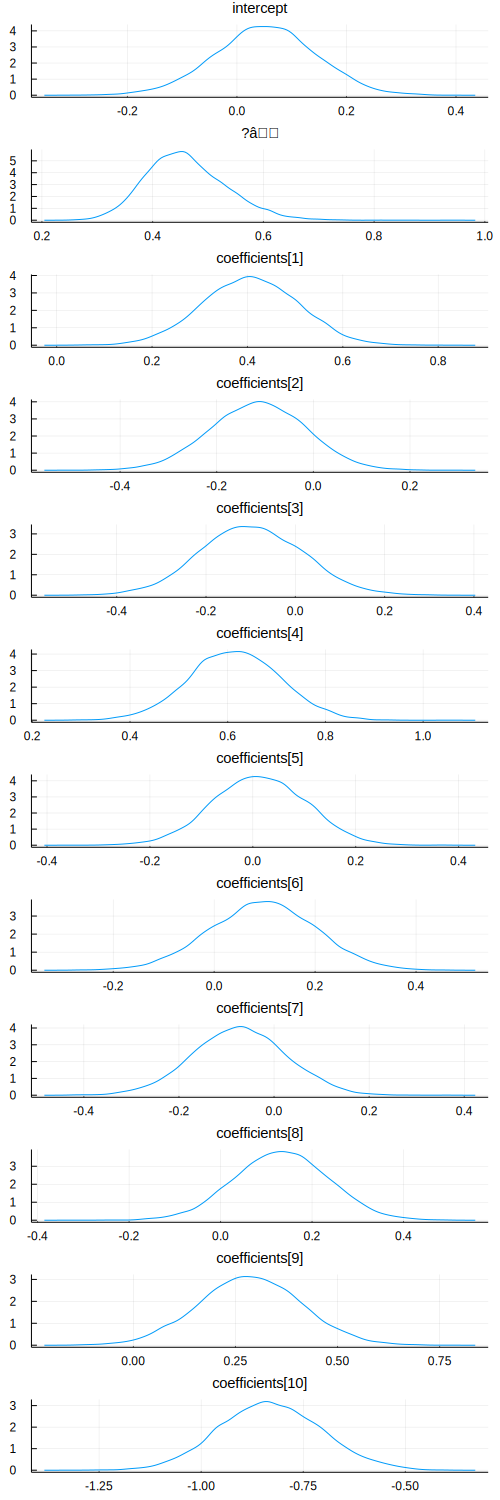

In [164]:
plot_variational_marginals(z, sym2range)

And let's compare this to using the `NUTS` sampler:

In [165]:
chain = sample(m, NUTS(0.65), 10_000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /var/home/tef30/.julia/dev/Turing/src/inference/hmc.jl:553
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:21


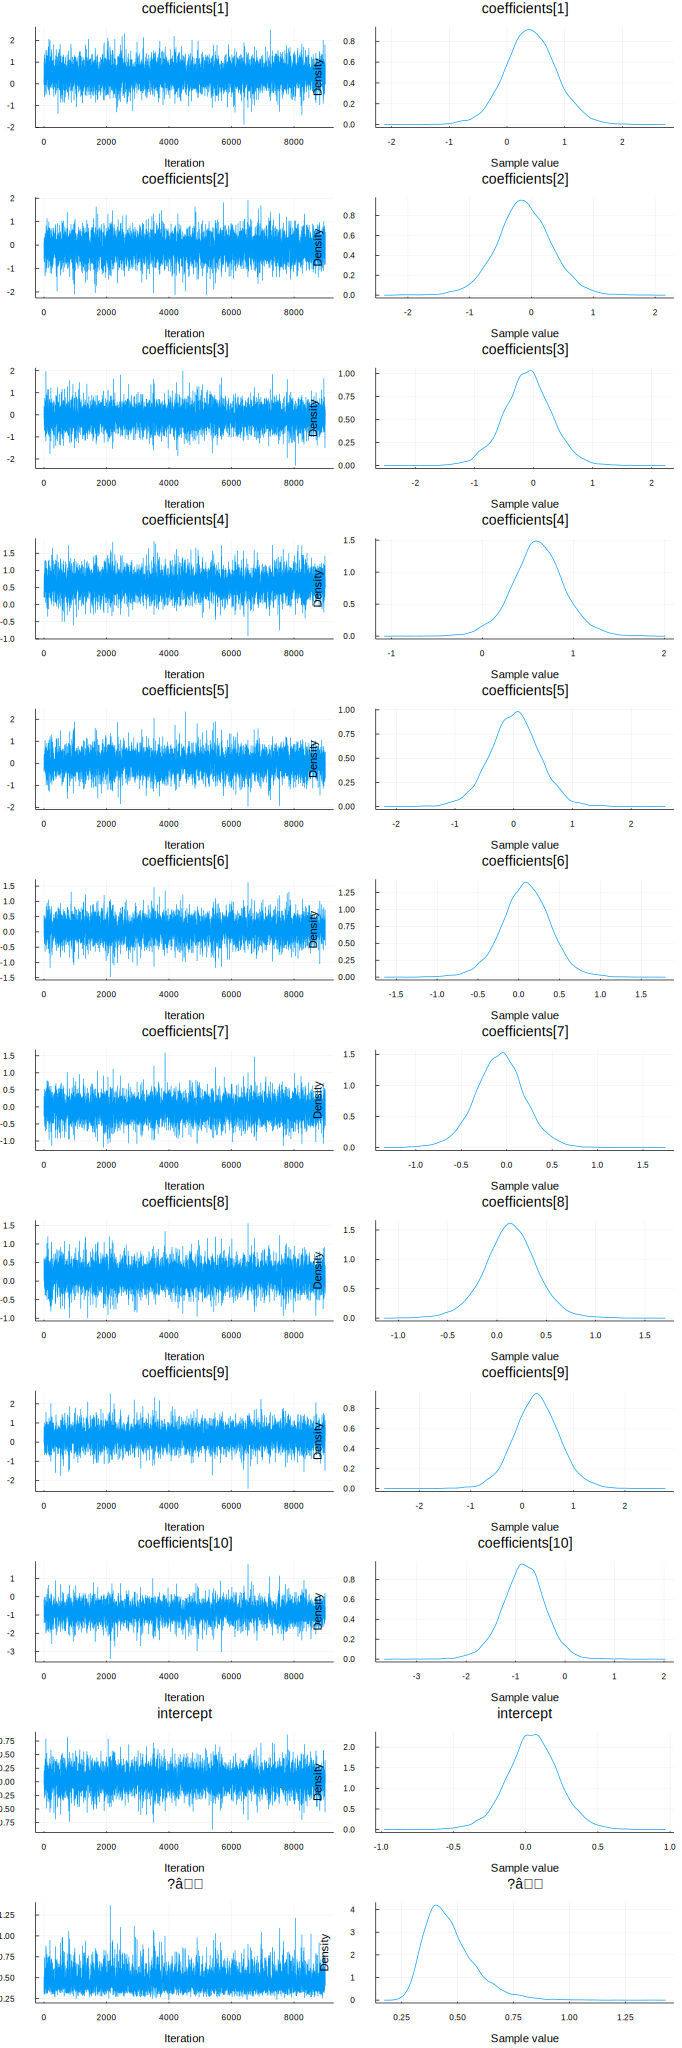

In [166]:
plot(chain)

In [167]:
vi_mean = vec(mean(z; dims = 2))[[union(sym2range[:coefficients]...)..., union(sym2range[:intercept]...)..., union(sym2range[:σ₂]...)...]]

12-element Array{Float64,1}:
  0.40642670061454966 
 -0.11468688188714656 
 -0.09745310785481291 
  0.6148587707658169  
  0.013081795791315748
  0.09698898180610958 
 -0.07232304322690837 
  0.13320265040493987 
  0.2856157877244301  
 -0.8298259636101167  
  0.05202909837745555 
  0.46063891764000514 

In [168]:
mean(chain).nt.mean

12-element Array{Float64,1}:
  0.4147867914451323  
 -0.11944188100447004 
 -0.09887211844022731 
  0.6162070922318873  
  0.016985387716866966
  0.0887471577838649  
 -0.07193715327044488 
  0.1378467113741552  
  0.2857983115635466  
 -0.8360351371919399  
  0.05074716018911719 
  0.46486129429583667 

One thing we can look at is simply the squared error between the means:

In [169]:
sum(abs2, mean(chain).nt.mean .- vi_mean)

0.0002592735852613781

That looks pretty good! But let's see how the predictive distributions looks for the two.

## Prediction

Similarily to the linear regression tutorial, we're going to compare to multivariate ordinary linear regression using the `GLM` package:

In [170]:
# Import the GLM package.
using GLM

# Perform multivariate OLS.
ols = lm(@formula(MPG ~ Cyl + Disp + HP + DRat + WT + QSec + VS + AM + Gear + Carb), train_cut)

# Store our predictions in the original dataframe.
train_cut.OLSPrediction = unstandardize(GLM.predict(ols), data.MPG);
test_cut.OLSPrediction = unstandardize(GLM.predict(ols, test_cut), data.MPG);

In [171]:
p = get_params(chain)

(hamiltonian_energy = Real[54.03466097834769; 54.551754532564864; … ; 61.83202663130254; 58.85095392036972], n_steps = Real[31; 15; … ; 63; 31], numerical_error = Real[false; false; … ; false; false], max_hamiltonian_energy_error = Real[-0.09005404539671957; 1.1117939457369275; … ; 0.782870354171294; -0.38896590121055397], σ₂ = Real[0.46315637074544763; 0.32419260570581027; … ; 0.4716389290336118; 0.4824723031775331], coefficients = (Real[0.4200699039555774; -0.04744594174429839; … ; -0.030093086491333944; 0.18565031649169003], Real[-0.055459330518965205; 0.11158292986713081; … ; 0.5543355285537745; -0.24035599994373835], Real[-0.15468787455853156; -0.15304513940654135; … ; 0.20544373403821342; -0.08298002018095413], Real[0.3794541314748382; 0.22982977841739544; … ; 0.4779553886468576; 0.5095186662239013], Real[-0.2704032895048856; -0.3684164259855581; … ; -0.7019990530918616; 0.07549145936000752], Real[0.13643031428553215; 0.44044111035519573; … ; 0.45463744756854246; 0.23091876308982

In [172]:
train

22×10 Array{Float64,2}:
 -0.104988  -0.57062   -0.535093   …   1.1899     0.423554   0.735203
 -0.104988  -0.57062   -0.535093       1.1899     0.423554   0.735203
 -1.22486   -0.990182  -0.78304        1.1899     0.423554  -1.12215 
 -0.104988   0.220094  -0.535093      -0.814143  -0.931819  -1.12215 
  1.01488    1.04308    0.412942      -0.814143  -0.931819  -0.503034
 -0.104988  -0.046167  -0.608019   …  -0.814143  -0.931819  -1.12215 
  1.01488    1.04308    1.4339        -0.814143  -0.931819   0.735203
 -1.22486   -0.677931  -1.23518       -0.814143   0.423554  -0.503034
 -1.22486   -0.725535  -0.75387       -0.814143   0.423554  -0.503034
 -0.104988  -0.509299  -0.345486      -0.814143   0.423554   0.735203
 -0.104988  -0.509299  -0.345486   …  -0.814143   0.423554   0.735203
  1.01488    0.363713   0.485868      -0.814143  -0.931819   0.116085
  1.01488    0.363713   0.485868      -0.814143  -0.931819   0.116085
  1.01488    0.363713   0.485868      -0.814143  -0.931819   0.116

In [173]:
hcat(collect.(p.coefficients)...)'

10×9000 Adjoint{Real,Array{Real,2}}:
  0.42007    -0.0474459   0.290669   …   0.855004    -0.0300931   0.18565  
 -0.0554593   0.111583    0.097876      -0.830504     0.554336   -0.240356 
 -0.154688   -0.153045   -0.0571616      0.0296042    0.205444   -0.08298  
  0.379454    0.22983     0.202356       0.569065     0.477955    0.509519 
 -0.270403   -0.368416   -0.341567       0.499114    -0.701999    0.0754915
  0.13643     0.440441    0.557595   …  -0.443993     0.454637    0.230919 
  0.115446   -0.277302   -0.222557       0.283865    -0.50956    -0.538362 
  0.129727    0.364109    0.620887       0.00363745  -0.178027    0.112775 
  0.229707   -0.0396628   0.124382       0.430935     0.759975    0.37751  
 -0.517308   -0.134491   -0.41956       -1.27292     -0.562382   -0.804954 

In [174]:
mean(p.intercept' .+ train * hcat(collect.(p.coefficients)...)'; dims = 2)

22×1 Array{Float64,2}:
  0.1314910648029324   
  0.16372966785032642  
  1.1956447367541958   
 -0.0031875403422014907
 -0.14119843495764764  
 -0.2899773241576725   
 -1.264550650098912    
  0.30893617569990584  
  0.6754364838279909   
 -0.1848923856933199   
 -0.1550938483952756   
 -0.6472581569397736   
 -0.6432274910438291   
 -0.6224938318838508   
 -1.5020539225095826   
 -1.4291620422502165   
 -1.1876851166347715   
  1.56851616281713     
  1.9962641269275405   
  1.7536492772145031   
  0.41377599926834935  
 -0.5201991571977277   

In [175]:
# Make a prediction given an input vector.
function prediction_chain(chain, x)
    p = get_params(chain)
    α = mean(p.intercept)
    β = collect(mean.(p.coefficients))
    return  α .+ x * β
end

prediction_chain (generic function with 1 method)

In [176]:
# Make a prediction using samples from the variational posterior given an input vector.
function prediction(samples, sym2ranges, x)
    α = mean(samples[union(sym2ranges[:intercept]...)])
    β = collect(mean.(samples[union(sym2ranges[:coefficients]...)]))
    return  α .+ x * β
end

prediction (generic function with 1 method)

In [177]:
z = rand(q, 10_000);

In [178]:
# Unstandardize the dependent variable.
train_cut.MPG = unstandardize(train_cut.MPG, data.MPG);
test_cut.MPG = unstandardize(test_cut.MPG, data.MPG);

In [179]:
# Show the first side rows of the modified dataframe.
first(test_cut, 6)

,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,116.195,1.01488,0.591245,0.0483133,-0.835198,0.222544,-0.307089,-0.868028
2,114.295,1.01488,0.962396,1.4339,0.249566,0.636461,-1.36476,-0.868028
3,120.195,1.01488,1.36582,0.412942,-0.966118,0.641571,-0.446992,-0.868028
4,128.295,-1.22486,-1.22417,-1.17684,0.904164,-1.31048,0.588295,1.11604
5,126.995,-1.22486,-0.890939,-0.812211,1.55876,-1.10097,-0.642858,-0.868028
6,131.395,-1.22486,-1.09427,-0.491337,0.324377,-1.74177,-0.530935,1.11604


In [180]:
# Calculate the predictions for the training and testing sets.
train_cut.VIPredictions = unstandardize(prediction(z, sym2range, train), data.MPG);
test_cut.VIPredictions = unstandardize(prediction(z, sym2range, test), data.MPG);

train_cut.BayesPredictions = unstandardize(prediction_chain(chain, train), data.MPG);
test_cut.BayesPredictions = unstandardize(prediction_chain(chain, test), data.MPG);

In [181]:
vi_loss1 = sum((train_cut.VIPredictions - train_cut.MPG).^2)
bayes_loss1 = sum((train_cut.BayesPredictions - train_cut.MPG).^2)
ols_loss1 = sum((train_cut.OLSPrediction - train_cut.MPG).^2)

vi_loss2 = sum((test_cut.VIPredictions - test_cut.MPG).^2)
bayes_loss2 = sum((test_cut.BayesPredictions - test_cut.MPG).^2)
ols_loss2 = sum((test_cut.OLSPrediction - test_cut.MPG).^2)

println("Training set:
    VI loss: $vi_loss1
    Bayes loss: $bayes_loss1
    OLS loss: $ols_loss1
Test set: 
    VI loss: $vi_loss2
    Bayes loss: $bayes_loss2
    OLS loss: $ols_loss2")

Training set:
    VI loss: 74.00391199394997
    Bayes loss: 67.56634100432407
    OLS loss: 67.5603747476466
Test set: 
    VI loss: 328.243501058699
    Bayes loss: 272.9732792900136
    OLS loss: 270.94813070760387


Unfortunately, the performance is generally worse for the variational approximation. On the bright side this means that all the work we do to make MCMC methods fast isn't just for granted, eh? It also demonstrates nicely that even though VI is very convenient, it's not always the best approach.

## Why are the results different?

There are two major drawbacks with using a mean-field approximation (the one obtained by `Variational.meanfield`) in`ADVI`:
- It assumes the different latent variables are *independently* distributed
- It assumes each latent variable can be described by a bijective transformation of a normal distribution

Now, both of these assumptions can be overcome to some degree by different choices of variational families or methods, but that is beyond the scope of this tutorial.

Instead we'll try to investigate which of the two assumptions above are wrong. Since our generative model used `MvNormal` for the prior over the `coefficients`, the normal assumption is indeed true for the `coefficients` part of the latent space. For the rest, it's probably not *that* significant. Therefore, investigating the independence property is more likely to be a fruitful direction.

Let's first look at the `coefficients`:

In [182]:
W = z[3:12, :]

10×10000 Array{Float64,2}:
  0.518403    0.37431      0.550901   …   0.598041    0.362053    0.370138 
 -0.210516   -0.111153    -0.0436758      0.0031057  -0.038433   -0.209509 
 -0.135421    0.00924546  -0.164481      -0.198285    0.0477602  -0.130743 
  0.689404    0.607657     0.67051        0.613261    0.560836    0.535629 
  0.0755686   0.154182    -0.0389226      0.105364    0.0424579  -0.0653831
  0.0573372   0.175886     0.373446   …   0.0789152  -0.0392471   0.09885  
 -0.0963032  -0.0689741    0.0884303     -0.0699708  -0.0912941  -0.103963 
  0.213394    0.0451139    0.155803       0.207916    0.0296397   0.032492 
  0.153753    0.269243     0.530083       0.469264    0.325902    0.461664 
 -0.884698   -0.727358    -0.756584      -0.517825   -0.817489   -0.913557 

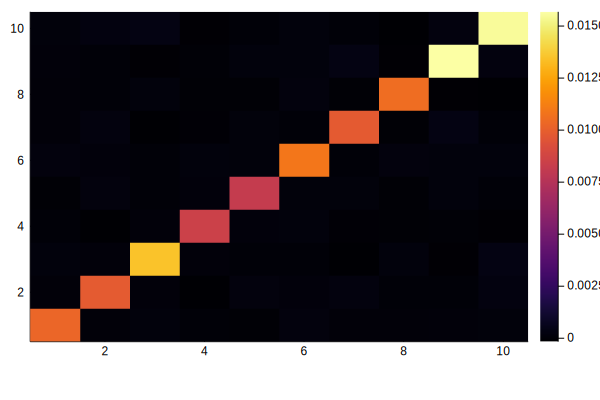

In [183]:
heatmap(cov(W'))

Indeed this looks the covariance matrix of a multivariate random variable with each dimension being independent of the others; great! Now let's look at the `coefficients` from the `chain` obtained using `NUTS`:

In [184]:
W = chain[200:25:end][:coefficients].value
W = reshape(W, (size(W, 1), size(W, 2)))'

10×353 Adjoint{Real,Base.ReshapedArray{Real,2,AxisArrays.AxisArray{Real,3,Array{Real,3},Tuple{AxisArrays.Axis{:iter,StepRange{Int64,Int64}},AxisArrays.Axis{:var,Array{String,1}},AxisArrays.Axis{:chain,UnitRange{Int64}}}},Tuple{}}}:
 -0.0848997   0.164772    0.742116  …   1.12869    -0.0795594   0.18565  
 -0.893575    0.485474   -0.546886      0.0276984   0.130776   -0.240356 
 -0.204539   -0.1947     -0.631002      0.0588555   0.213995   -0.08298  
  0.953434    0.983929    1.27286       0.156378    0.374139    0.509519 
  1.08924    -0.200038    1.29807      -0.517663   -0.184909    0.0754915
 -0.604431    0.393385   -0.358244  …   0.532374    0.108222    0.230919 
 -0.273585   -0.0450506  -0.803087      0.206265   -0.109098   -0.538362 
 -0.683214    0.420218   -0.431575      0.613013    0.28416     0.112775 
  0.680734   -0.497752    1.0569        0.613949    0.451454    0.37751  
 -1.38053    -0.437905   -2.5836       -0.57934    -0.784385   -0.804954 

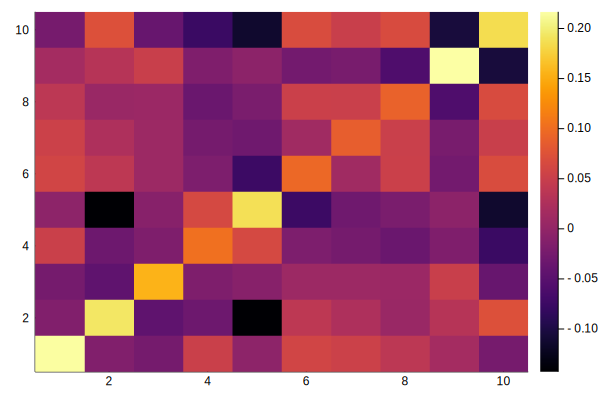

In [185]:
heatmap(cov(W'))

This looks very much different from correlation matrix for the variational posterior! This indicates that correlation structure for `coefficients` is useful for making predictions, which intuitively one would expect, e.g. some features grouped together are more important for predictions than on their own.

## Alternative: provide $\theta \mapsto q_{\theta}$ instead of `q` with`update` implemented

As mentioned earlier, it's also possible to just provide the mapping $\theta \mapsto q_{\theta}$ rather than the variational family / initial variational posterior `q`, i.e. use the interface `vi(m, advi, getq, θ_init)` where `getq` is the mapping $\theta \mapsto q_{\theta}$

In this section we're going to construct a mean-field approximation to the model by hand using a composition of`Shift` and `Scale` from Bijectors.jl togheter with a standard multivariate Gaussian as the base distribution. 

In [186]:
using Bijectors

In [187]:
using Bijectors: Scale, Shift

In [188]:
d = length(q)
base_dist = Turing.DistributionsAD.TuringDiagMvNormal(zeros(d), ones(d))

DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
σ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
)


`bijector(model::Turing.Model)` is defined by Turing, and will return a `bijector` which takes you from the space of the latent variables to the real space. In this particular case, this is a mapping `((0, ∞) × ℝ × ℝ¹⁰) → ℝ¹²`. We're interested in using a normal distribution as a base-distribution and transform samples to the latent space, thus we need the inverse mapping from the reals to the latent space:

In [189]:
to_constrained = inv(bijector(m));

In [190]:
function getq(θ)
    d = length(θ) ÷ 2
    A = @inbounds θ[1:d]
    b = @inbounds θ[d + 1: 2 * d]
    
    b = to_constrained ∘ Shift(b; dim = Val(1)) ∘ Scale(exp.(A); dim = Val(1))
    
    return transformed(base_dist, b)
end

getq (generic function with 1 method)

In [191]:
q0 = getq(randn(2 * d))

TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Composed{Tuple{Scale{Array{Float64,1},1},Shift{Array{Float64,1},1},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3}},1},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
σ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
)

transform: Composed{Tuple{Scale{Array{Float64,1},1},Shift{Array{Float64,1},1},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3}},1}((Scale{Array{Float64,1},1}([0.18522894391796135, 1.2156215393218979, 1.278253440643974, 0.41188677479370917, 2.1064410896779604, 1.8743812762148286, 1.5234419979745049, 1.1687512901068693, 0.24440100872654244, 2.152862272849771, 7.963685007032424, 1.2447316647605504]), Shift{Array{Float64,1},1}([-0.6420062123462035, 0.8128424159885815, 1.3209938495

In [192]:
q1 = vi(m, advi, getq, randn(2 * d))

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 8281686115716730039
└ @ Turing.Variational /var/home/tef30/.julia/dev/Turing/src/variational/VariationalInference.jl:161
[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:00:14


TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Composed{Tuple{Scale{Array{Float64,1},1},Shift{Array{Float64,1},1},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3}},1},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
σ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
)

transform: Composed{Tuple{Scale{Array{Float64,1},1},Shift{Array{Float64,1},1},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3}},1}((Scale{Array{Float64,1},1}([0.15742860298850125, 0.09364093301501872, 0.10405185167077442, 0.09737955792536147, 0.11309881753369648, 0.08749853825936971, 0.09213024691863578, 0.09839734507000536, 0.09452126902824205, 0.10035717746708189, 0.13909242869420896, 0.12710802583190467]), Shift{Array{Float64,1},1}([-0.8118311414663258, 0.034892904504496135

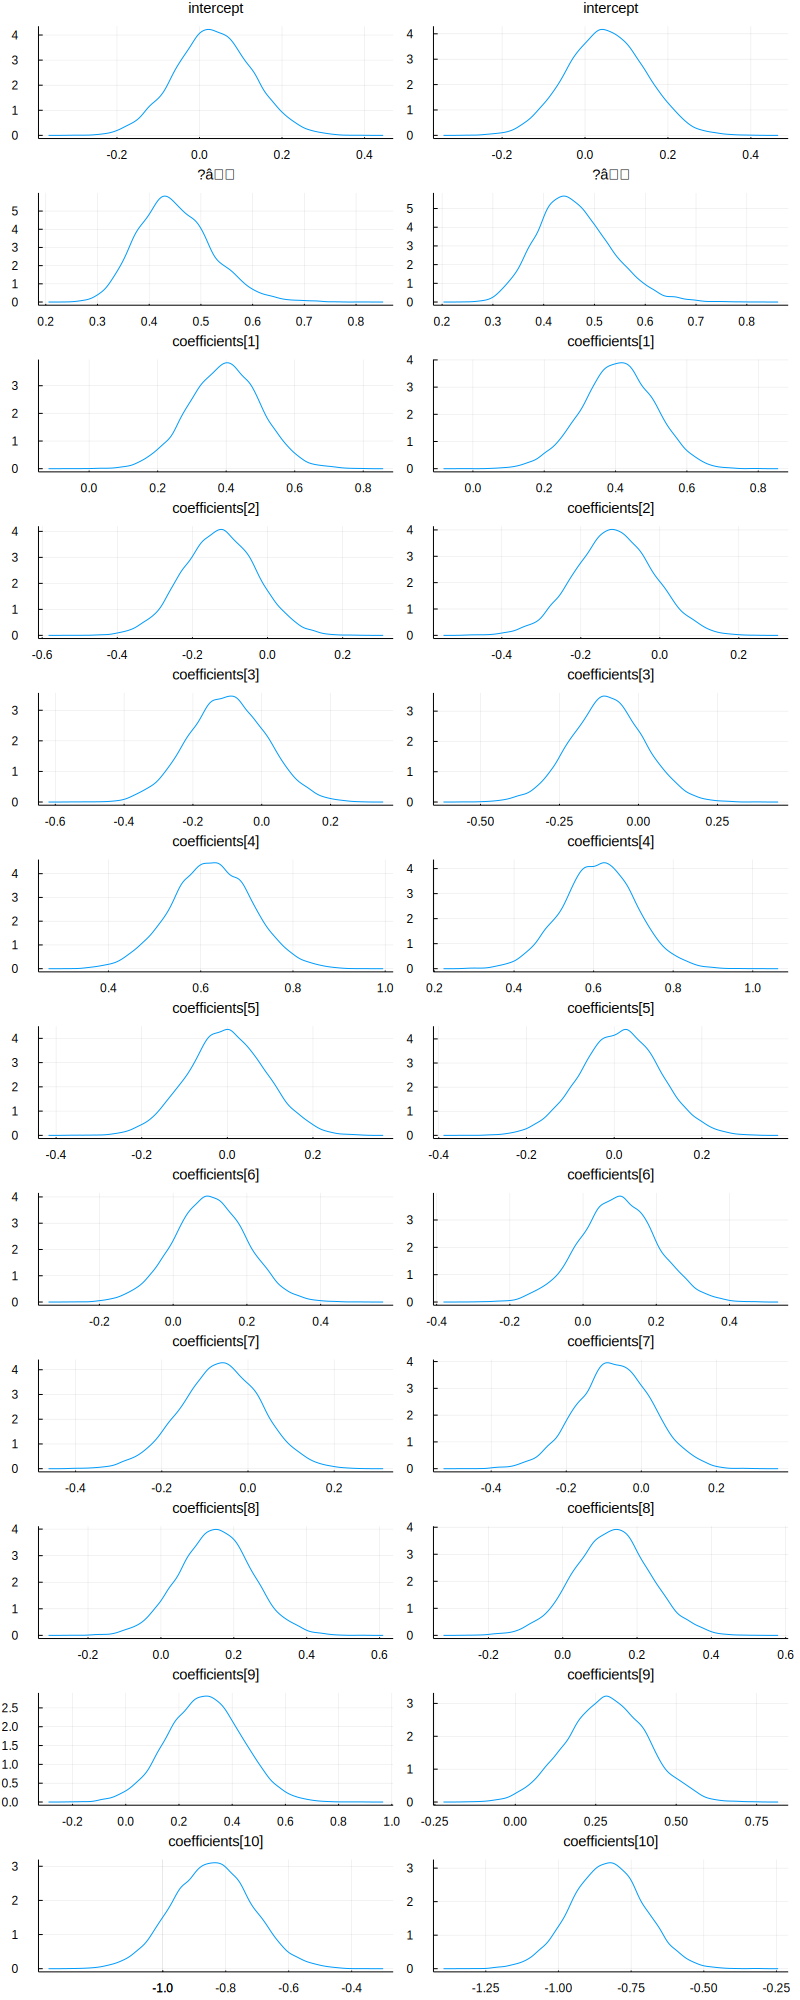

In [193]:
p1 = plot_variational_marginals(rand(q1, 10_000), sym2range) # MvDiagNormal + Affine transformation + to_constrained
p2 = plot_variational_marginals(rand(q, 10_000), sym2range)  # Turing.meanfield(m)

plot(p1, p2, layout = (1, 2), size = (800, 2000))

As expected, the fits look pretty much identical.

In [194]:
using LinearAlgebra

In [195]:
d = 12

function getq(θ)
    offset = 0
    L = LowerTriangular(reshape(@inbounds(θ[offset + 1: offset + d^2]), (d, d)))
    offset += d^2
    b = @inbounds θ[offset + 1: offset + d]
    
    # For this to represent a covariance matrix we need to ensure that the diagonal is positive.
    # We can enforce this by zeroing out the diagonal and then adding back the diagonal exponentiated.
    D = Diagonal(diag(L))
    A = L - D + exp(D) # exp for Diagonal is the same as exponentiating only the diagonal entries
    
    b = to_constrained ∘ Shift(b; dim = Val(1)) ∘ Scale(A; dim = Val(1))
    
    return transformed(base_dist, b)
end

getq (generic function with 1 method)

In [196]:
θ = randn(d^2 + d);

In [197]:
q2 = getq(θ)

TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Composed{Tuple{Scale{LowerTriangular{Float64,Array{Float64,2}},1},Shift{Array{Float64,1},1},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3}},1},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
σ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
)

transform: Composed{Tuple{Scale{LowerTriangular{Float64,Array{Float64,2}},1},Shift{Array{Float64,1},1},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3}},1}((Scale{LowerTriangular{Float64,Array{Float64,2}},1}([1.7687317710695656 0.0 … 0.0 0.0; 0.4563593363355033 3.3845007083024563 … 0.0 0.0; … ; -1.2904375239963009 0.8929814669263504 … 5.150867460375926 0.0; -0.17521213576969294 0.8269699931464068 … -1.5480139172862286 2.142591466478302]), Shift{Array{F

In [198]:
advi = ADVI(10, 20_000)

ADVI{Turing.Core.ForwardDiffAD{40}}(10, 20000)

In [199]:
q2 = vi(m, advi, getq, randn(d^2 + d); optimizer = Variational.DecayedADAGrad(1e-2))

[ADVI] Optimizing...: 100%|█████████████████████████████████████████| Time: 0:02:57


TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Composed{Tuple{Scale{LowerTriangular{Float64,Array{Float64,2}},1},Shift{Array{Float64,1},1},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3}},1},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
σ: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
)

transform: Composed{Tuple{Scale{LowerTriangular{Float64,Array{Float64,2}},1},Shift{Array{Float64,1},1},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{Float64},0},Identity{0},Identity{1}},3}},1}((Scale{LowerTriangular{Float64,Array{Float64,2}},1}([0.1575855954621829 0.0 … 0.0 0.0; -0.009001644138225275 0.1842062200527963 … 0.0 0.0; … ; -0.01850663119256931 0.31914506815052246 … 0.13155017036088196 0.0; -0.004588856754446663 -0.12095824394003422 … -0.007525031143200642 0.1283245526868655]), 

Let's have a look at the learned covariance matrix:

In [200]:
A = q2.transform.ts[1].a

12×12 LowerTriangular{Float64,Array{Float64,2}}:
  0.157586      ⋅            ⋅          …    ⋅           ⋅           ⋅      
 -0.00900164   0.184206      ⋅               ⋅           ⋅           ⋅      
 -0.00762957  -0.0378071    0.445294         ⋅           ⋅           ⋅      
 -0.00527298   0.0682124   -0.00360446       ⋅           ⋅           ⋅      
 -0.0250535    0.229705    -0.0328967        ⋅           ⋅           ⋅      
 -0.00140223  -0.0739627    0.0806002   …    ⋅           ⋅           ⋅      
  0.0266412   -0.0712488   -0.0271972        ⋅           ⋅           ⋅      
 -0.00286464  -0.0367452    0.128146         ⋅           ⋅           ⋅      
 -0.00786921   0.00118242   0.102707         ⋅           ⋅           ⋅      
  0.00162656  -0.0407668    0.0756478       0.150536     ⋅           ⋅      
 -0.0185066    0.319145     0.100979    …  -0.134673    0.13155      ⋅      
 -0.00458886  -0.120958    -0.067946        0.0313597  -0.00752503  0.128325

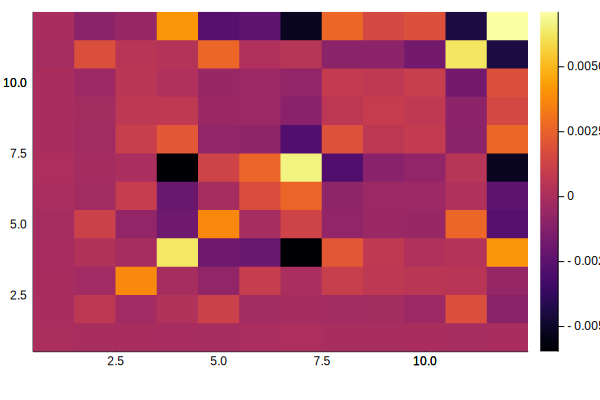

In [201]:
heatmap(cov(A * A'))

In [202]:
zs = rand(q2, 10_000);

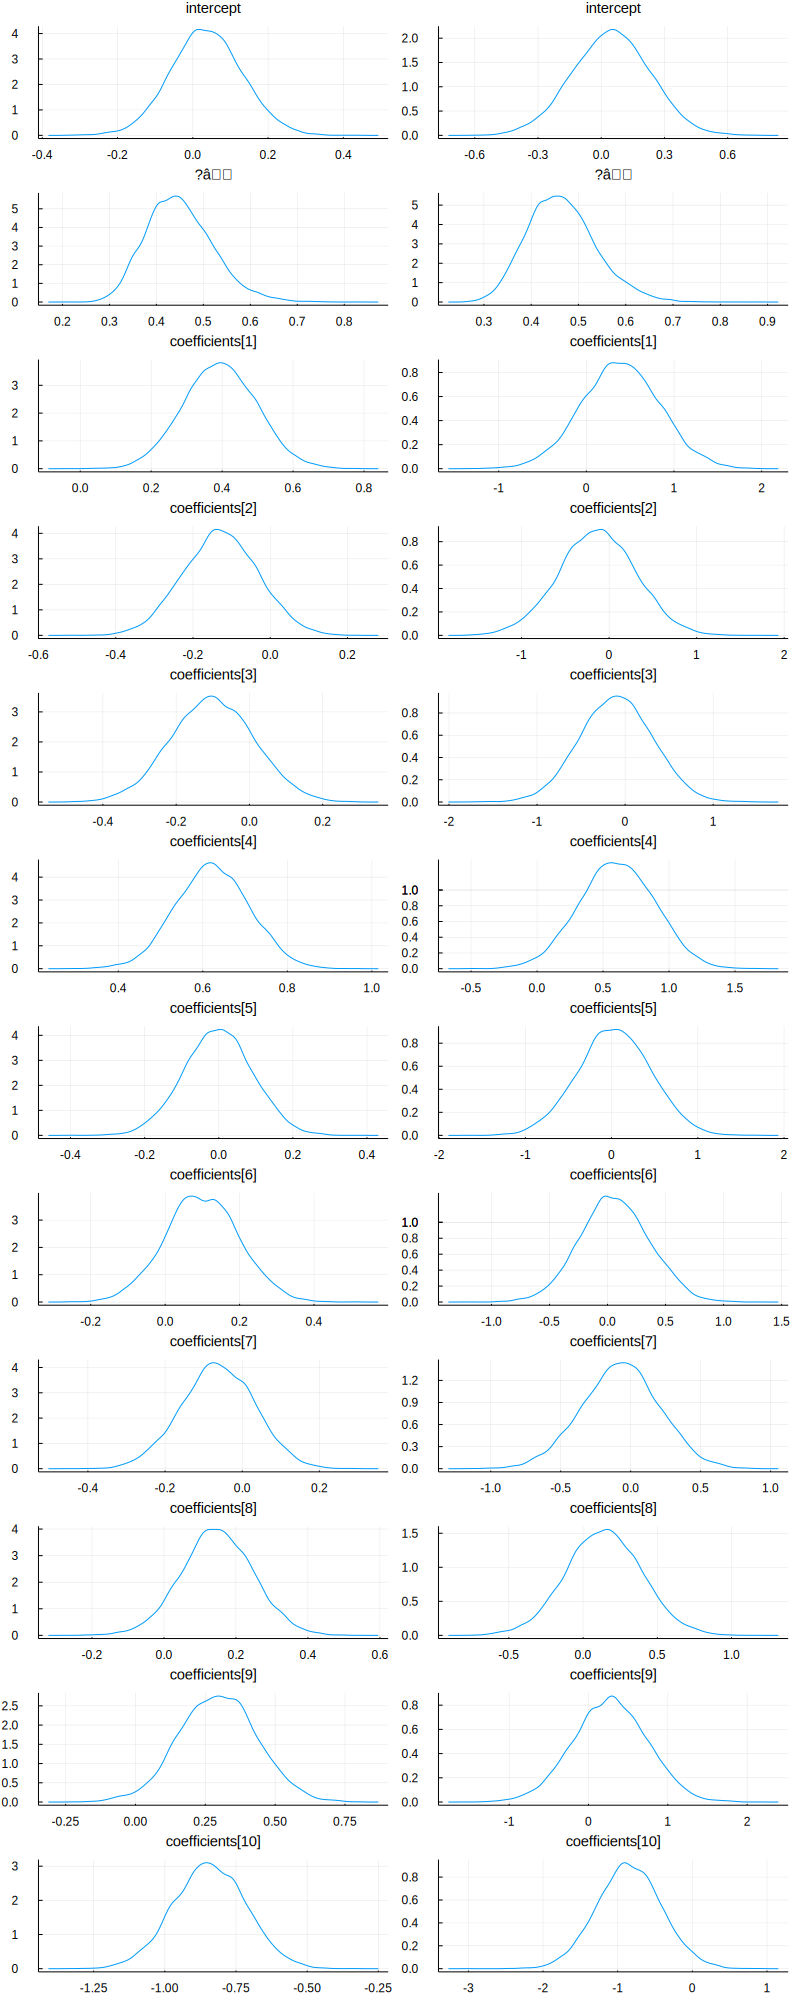

In [203]:
p1 = plot_variational_marginals(rand(q1, 10_000), sym2range)
p2 = plot_variational_marginals(rand(q2, 10_000), sym2range)

plot(p1, p2, layout = (1, 2), size = (800, 2000))

So it seems like the "full" ADVI approach, i.e. no mean-field assumption, obtain the same modes as the mean-field approach but with greater uncertainty for some of the `coefficients`. This 

In [204]:
# Unfortunately, it seems like this has quite a high variance which is likely to be due to numerical instability, 
# so we consider a larger number of samples. If we get a couple of outliers due to numerical issues, 
# these kind affect the mean prediction greatly.
z = rand(q2, 100);

In [206]:
preds = hcat([unstandardize(prediction(z[:, i], sym2range, train), data.MPG) for i = 1:size(z, 2)]...)

22×100 Array{Float64,2}:
 122.491  123.658  124.391  119.323  …  120.483  121.567  119.79   120.315
 121.692  123.166  124.094  118.915     121.018  121.777  119.27   120.778
 124.473  128.792  130.034  129.304     130.87   125.92   131.304  129.492
 125.008  124.224  121.021  120.587     120.345  123.387  122.756  123.936
 120.275  120.311  121.062  119.202     118.679  123.199  121.039  120.951
 121.401  122.178  118.512  117.953  …  118.288  120.167  119.749  121.924
 114.556  115.924  115.027  113.207     114.401  117.152  114.321  115.557
 123.674  125.419  122.895  125.867     125.99   119.95   122.747  118.745
 123.342  126.047  129.144  123.53      126.037  126.01   122.927  123.594
 120.05   121.234  118.699  122.081     122.556  122.149  121.491  119.22 
 120.227  121.475  119.55   121.206  …  121.976  123.179  121.232  119.769
 114.648  115.262  115.481  116.031     117.868  116.181  114.066  117.587
 115.992  116.298  117.22   115.193     116.238  117.524  114.352  117.836


In [207]:
train_cut.VIFullPredictions = unstandardize(prediction(z, sym2range, train), data.MPG);
test_cut.VIFullPredictions = unstandardize(prediction(z, sym2range, test), data.MPG);

In [208]:
vi_loss1 = mean((train_cut.VIPredictions - train_cut.MPG).^2)
vifull_loss1 = mean((train_cut.VIFullPredictions - train_cut.MPG).^2)
bayes_loss1 = mean((train_cut.BayesPredictions - train_cut.MPG).^2)
ols_loss1 = mean((train_cut.OLSPrediction - train_cut.MPG).^2)

vi_loss2 = mean((test_cut.VIPredictions - test_cut.MPG).^2)
vifull_loss2 = mean((test_cut.VIFullPredictions - test_cut.MPG).^2)
bayes_loss2 = mean((test_cut.BayesPredictions - test_cut.MPG).^2)
ols_loss2 = mean((test_cut.OLSPrediction - test_cut.MPG).^2)

println("Training set:
    VI loss:        $vi_loss1
    VI (full) loss: $vifull_loss1
    Bayes loss:     $bayes_loss1
    OLS loss:       $ols_loss1
Test set: 
    VI loss:        $vi_loss2
    VI (full) loss: $vifull_loss2
    Bayes loss:     $bayes_loss2
    OLS loss:       $ols_loss2")

Training set:
    VI loss:        3.3638141815431806
    VI (full) loss: 8.208370529629642
    Bayes loss:     3.071197318378367
    OLS loss:       3.0709261248930275
Test set: 
    VI loss:        32.8243501058699
    VI (full) loss: 89.75051886797334
    Bayes loss:     27.29732792900136
    OLS loss:       27.094813070760388


In [217]:
z = rand(q1, 1000);
preds = hcat([unstandardize(prediction(z[:, i], sym2range, test), data.MPG) for i = 1:size(z, 2)]...);

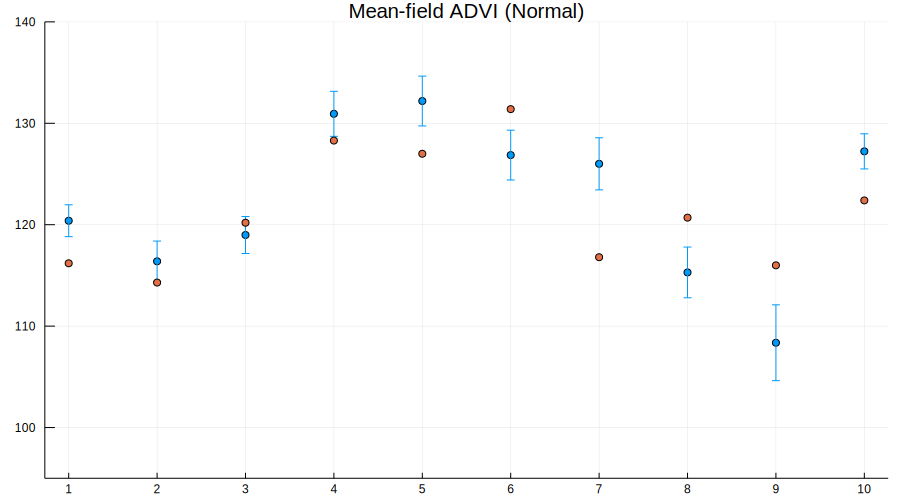

In [218]:
p1 = scatter(1:size(test, 1), mean(preds; dims = 2), yerr=std(preds; dims = 2), label="", size = (900, 500))
scatter!(1:size(test, 1), unstandardize(test_label, data.MPG), label="")
xaxis!(1:size(test, 1))
ylims!(95, 140)
title!("Mean-field ADVI (Normal)")

In [219]:
z = rand(q2, 1000);
preds = hcat([unstandardize(prediction(z[:, i], sym2range, test), data.MPG) for i = 1:size(z, 2)]...);

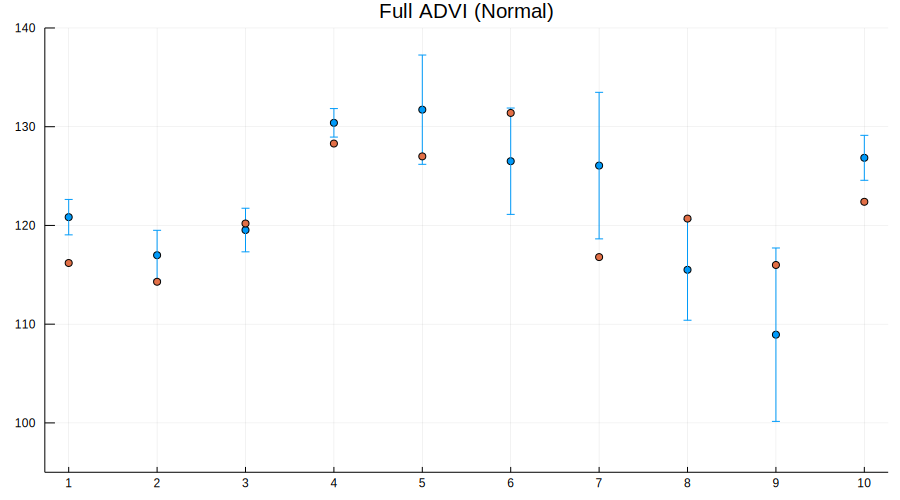

In [220]:
p2 = scatter(1:size(test, 1), mean(preds; dims = 2), yerr=std(preds; dims = 2), label="", size = (900, 500))
scatter!(1:size(test, 1), unstandardize(test_label, data.MPG), label="")
xaxis!(1:size(test, 1))
ylims!(95, 140)
title!("Full ADVI (Normal)")

In [221]:
preds = hcat([unstandardize(prediction_chain(chain[i], test), data.MPG) for i = 1:5:size(chain, 1)]...);

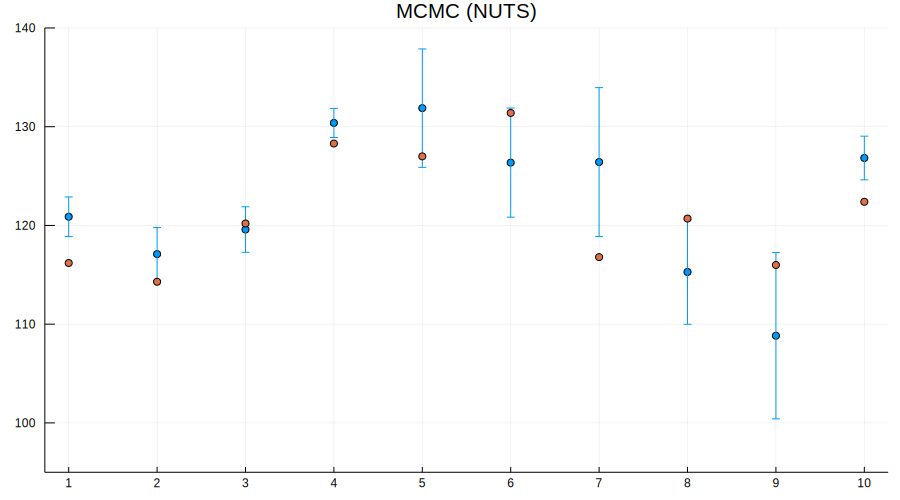

In [222]:
p3 = scatter(1:size(test, 1), mean(preds; dims = 2), yerr=std(preds; dims = 2), label="", size = (900, 500))
scatter!(1:size(test, 1), unstandardize(test_label, data.MPG), label="")
xaxis!(1:size(test, 1))
ylims!(95, 140)
title!("MCMC (NUTS)")

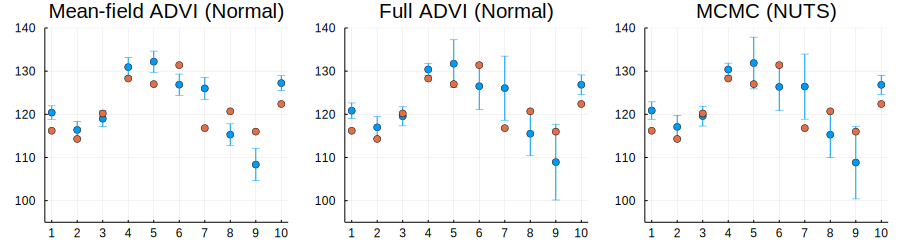

In [223]:
plot(p1, p2, p3, layout = (1, 3), size = (900, 250))

Here we actually see that indeed both the full ADVI and the MCMC approaches does a much better job of quantifying the uncertainty of predictions for never-before-seen samples!